# Crime Analysis for Neighborhoods in Vancouver

In [1]:
!pip install xlrd
import xlrd
print('Finished!')

     |████████████████████████████████| 112kB 23.4MB/s eta 0:00:01
Finished!


In [2]:
#importing libraries
import numpy as np
import pandas as pd
import json

import requests
from pandas.io.json import json_normalize

from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium

import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib.pyplot as plt
import seaborn as sns

### Step 1: Getting Data

In [3]:
df=pd.read_csv('crime_records.csv')
print(df.shape)
df.head()

(558937, 10)


,TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
0,Break and Enter Commercial,2012.0,12.0,14.0,8.0,52.0,NaN,Oakridge,491285.000000,5.453433e+06
1,Break and Enter Commercial,2019.0,3.0,7.0,2.0,6.0,10XX SITKA SQ,Fairview,490612.964805,5.457110e+06
2,Break and Enter Commercial,2019.0,8.0,27.0,4.0,12.0,10XX ALBERNI ST,West End,491007.779775,5.459174e+06
3,Break and Enter Commercial,2014.0,8.0,8.0,5.0,13.0,10XX ALBERNI ST,West End,491015.943352,5.459166e+06
4,Break and Enter Commercial,2005.0,11.0,14.0,3.0,9.0,10XX ALBERNI ST,West End,491021.385727,5.459161e+06


In [4]:
df1 =pd.read_excel(r'Location.xlsx', sheet_name= 'Sheet1')
df1.head()

,Neighborhoods,Latitude,Longitude
0,Arbutus Ridge,49.257500,-123.174444
1,Downtown,49.279983,-123.121120
2,Dunbar-Southlands,49.250000,-123.185000
3,Fairview,49.264000,-123.130000
4,Grandview-Woodland,49.275000,-123.067000


### Step 2: Data Cleanup

In [5]:
df_crime = df.dropna(axis=0, subset=['NEIGHBOURHOOD'])
df_crime.shape

(494189, 10)

In [6]:
#delete NaN, Musqueam, Stanley Park rows
#change Central Business Districtto Downtown
df_crime.drop(df_crime[df_crime['NEIGHBOURHOOD']=='Musqueam'].index, inplace = True)
df_crime.drop(df_crime[df_crime['NEIGHBOURHOOD']=='Stanley Park'].index, inplace = True) 

df_crime['NEIGHBOURHOOD'].replace(to_replace='Central Business District', 
                                  value='Downtown', inplace=True)
print(df_crime.shape)
df_crime.head()

(489882, 10)


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/generic.py:6786: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


,TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
0,Break and Enter Commercial,2012.0,12.0,14.0,8.0,52.0,NaN,Oakridge,491285.000000,5.453433e+06
1,Break and Enter Commercial,2019.0,3.0,7.0,2.0,6.0,10XX SITKA SQ,Fairview,490612.964805,5.457110e+06
2,Break and Enter Commercial,2019.0,8.0,27.0,4.0,12.0,10XX ALBERNI ST,West End,491007.779775,5.459174e+06
3,Break and Enter Commercial,2014.0,8.0,8.0,5.0,13.0,10XX ALBERNI ST,West End,491015.943352,5.459166e+06
4,Break and Enter Commercial,2005.0,11.0,14.0,3.0,9.0,10XX ALBERNI ST,West End,491021.385727,5.459161e+06


In [7]:
#drop useless columns like Month,Day, Hour,Minute, Hundred_Block
df_crime.drop(['MONTH','DAY','HOUR','MINUTE','HUNDRED_BLOCK','X','Y'], axis=1, inplace=True)
df_crime.head()

,TYPE,YEAR,NEIGHBOURHOOD
0,Break and Enter Commercial,2012.0,Oakridge
1,Break and Enter Commercial,2019.0,Fairview
2,Break and Enter Commercial,2019.0,West End
3,Break and Enter Commercial,2014.0,West End
4,Break and Enter Commercial,2005.0,West End


In [8]:
#left join two dataframes
df_combine = pd.merge(df1, df_crime, left_on='Neighborhoods', right_on='NEIGHBOURHOOD', how='left')
df_combine.head()

,Neighborhoods,Latitude,Longitude,TYPE,YEAR,NEIGHBOURHOOD
0,Arbutus Ridge,49.2575,-123.174444,Break and Enter Commercial,2005.0,Arbutus Ridge
1,Arbutus Ridge,49.2575,-123.174444,Break and Enter Commercial,2007.0,Arbutus Ridge
2,Arbutus Ridge,49.2575,-123.174444,Break and Enter Commercial,2016.0,Arbutus Ridge
3,Arbutus Ridge,49.2575,-123.174444,Break and Enter Commercial,2016.0,Arbutus Ridge
4,Arbutus Ridge,49.2575,-123.174444,Break and Enter Commercial,2005.0,Arbutus Ridge


In [9]:
#clean dataframe
df_combine.drop(['NEIGHBOURHOOD'], axis=1, inplace=True)
df_combine.head()

,Neighborhoods,Latitude,Longitude,TYPE,YEAR
0,Arbutus Ridge,49.2575,-123.174444,Break and Enter Commercial,2005.0
1,Arbutus Ridge,49.2575,-123.174444,Break and Enter Commercial,2007.0
2,Arbutus Ridge,49.2575,-123.174444,Break and Enter Commercial,2016.0
3,Arbutus Ridge,49.2575,-123.174444,Break and Enter Commercial,2016.0
4,Arbutus Ridge,49.2575,-123.174444,Break and Enter Commercial,2005.0


### Step 3: Clustering Neighborhoods

In [10]:
#login to FourSquare
CLIENT_ID = 'CDRCGLMDYGOBYULYVN03XUUAPNEL4BH4HMNDBT4EG53NMU00' # your Foursquare ID
CLIENT_SECRET = '3VBEGHMHS1C0CJI34MBCJL13E4OKDM5SQC31FW2BQYF5WVKM' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT=10

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: CDRCGLMDYGOBYULYVN03XUUAPNEL4BH4HMNDBT4EG53NMU00
CLIENT_SECRET:3VBEGHMHS1C0CJI34MBCJL13E4OKDM5SQC31FW2BQYF5WVKM


In [11]:
#define the function to get nearby venues from FourSquare
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    #each item is a nearby venue in the nearby_venue list for each neighboor  
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [12]:
#Let's find out how many unique categories can be curated from all the returned venues
df_group= df_combine.groupby('Neighborhoods').count()
df_group

,Latitude,Longitude,TYPE,YEAR
Neighborhoods,,,,
Arbutus Ridge,5956,5956,5956,5956
Downtown,129798,129798,129798,129798
Dunbar-Southlands,7814,7814,7814,7814
Fairview,33333,33333,33333,33333
Grandview-Woodland,26850,26850,26850,26850
Hastings-Sunrise,17183,17183,17183,17183
Kensington-Cedar Cottage,23637,23637,23637,23637
Kerrisdale,7350,7350,7350,7350
Killarney,9773,9773,9773,9773


### < f1 find how many crimes occurred in each Neighborhood>

In [13]:
df_group_sort=df_group.sort_values(by='TYPE', ascending=False)

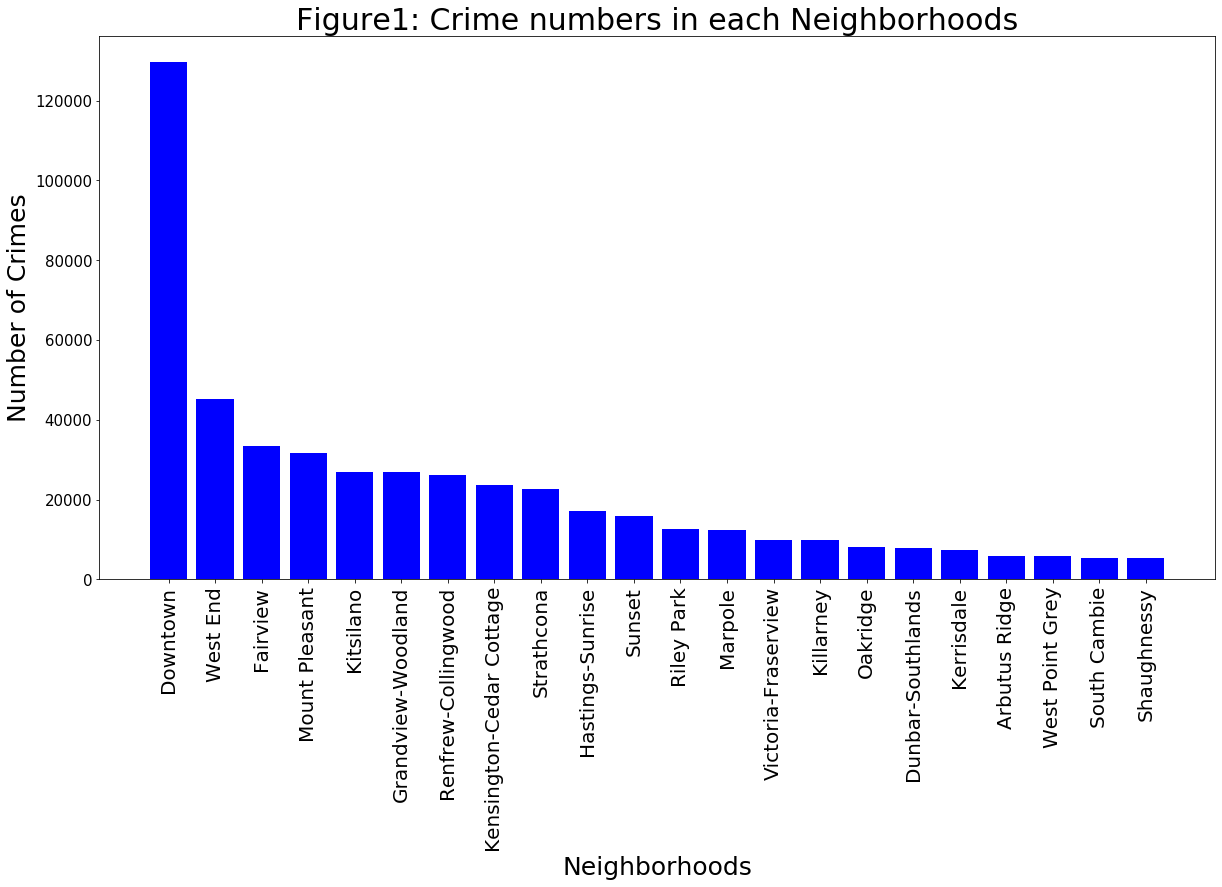

In [14]:
#getting the bar plot by pyplot
%matplotlib inline
from matplotlib.pyplot import figure
#set the figure size
plt.figure(figsize=(20,10))

plt.bar(df_group_sort.index.values, "TYPE", data=df_group_sort, color="blue")
plt.xlabel("Neighborhoods", fontsize=25)
plt.ylabel("Number of Crimes", fontsize=25)
plt.title("Figure1: Crime numbers in each Neighborhoods", fontsize=30)
plt.xticks(rotation = 90,fontsize=20)
plt.yticks(fontsize=15)

plt.show()

### </ f1>

### < f2 the crime changes from 2003 to 2019>

In [15]:
df_combine.head()

,Neighborhoods,Latitude,Longitude,TYPE,YEAR
0,Arbutus Ridge,49.2575,-123.174444,Break and Enter Commercial,2005.0
1,Arbutus Ridge,49.2575,-123.174444,Break and Enter Commercial,2007.0
2,Arbutus Ridge,49.2575,-123.174444,Break and Enter Commercial,2016.0
3,Arbutus Ridge,49.2575,-123.174444,Break and Enter Commercial,2016.0
4,Arbutus Ridge,49.2575,-123.174444,Break and Enter Commercial,2005.0


In [16]:
df_year= df_combine.groupby('YEAR').count()
df_year_sort=df_year.sort_values(by='YEAR', ascending=True)
df_year_sort.head()

,Neighborhoods,Latitude,Longitude,TYPE
YEAR,,,,
2003.0,37649,37649,37649,37649
2004.0,36926,36926,36926,36926
2005.0,33328,33328,33328,33328
2006.0,32511,32511,32511,32511
2007.0,28524,28524,28524,28524


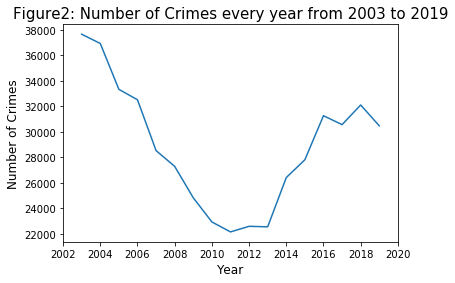

In [17]:
plt.plot(df_year_sort.index.values, df_year_sort['TYPE'])
plt.xlim(2002, 2020)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of Crimes", fontsize=12)
plt.title("Figure2: Number of Crimes every year from 2003 to 2019", fontsize=15)

plt.show()

### </ f2>

### < f3 find top crime categories>

In [18]:
df_combine.head()

,Neighborhoods,Latitude,Longitude,TYPE,YEAR
0,Arbutus Ridge,49.2575,-123.174444,Break and Enter Commercial,2005.0
1,Arbutus Ridge,49.2575,-123.174444,Break and Enter Commercial,2007.0
2,Arbutus Ridge,49.2575,-123.174444,Break and Enter Commercial,2016.0
3,Arbutus Ridge,49.2575,-123.174444,Break and Enter Commercial,2016.0
4,Arbutus Ridge,49.2575,-123.174444,Break and Enter Commercial,2005.0


In [19]:
df_type =df_combine.groupby('TYPE').count()
df_type_sort=df_type.sort_values(by='YEAR', ascending=False)
df_type_sort.head()

,Neighborhoods,Latitude,Longitude,YEAR
TYPE,,,,
Theft from Vehicle,204277,204277,204277,204277
Mischief,83279,83279,83279,83279
Break and Enter Residential/Other,66213,66213,66213,66213
Other Theft,64587,64587,64587,64587
Break and Enter Commercial,38803,38803,38803,38803


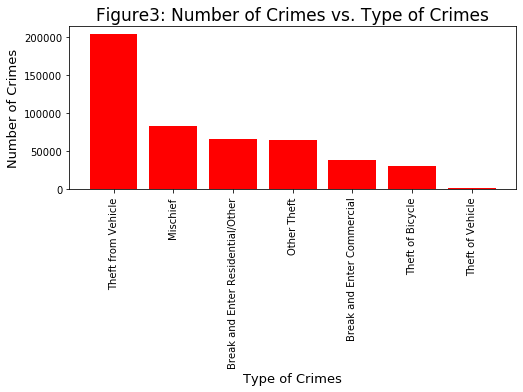

In [20]:
#getting the bar plot by pyplot
plt.figure(figsize=(8,3))

plt.bar(df_type_sort.index.values, "YEAR", data=df_type_sort, color="red")
plt.xlabel("Type of Crimes", fontsize=13)
plt.ylabel("Number of Crimes", fontsize=13)
plt.title("Figure3: Number of Crimes vs. Type of Crimes", fontsize=17)
plt.xticks(rotation = 90,fontsize=10)
plt.yticks(fontsize=10)

plt.show()

### </ f3>

In [21]:
#getting Vancouver's nearby vennues for all Neighborhoods
van_venues = getNearbyVenues(names=df1['Neighborhoods'],
                             latitudes=df1['Latitude'],
                             longitudes=df1['Longitude']
                            )
print(van_venues.shape)
van_venues.head()

Arbutus Ridge
Downtown
Dunbar-Southlands
Fairview
Grandview-Woodland
Hastings-Sunrise
Kensington-Cedar Cottage
Kerrisdale
Killarney
Kitsilano
Marpole
Mount Pleasant
Oakridge
Renfrew-Collingwood
Riley Park
Shaughnessy
South Cambie
Strathcona
Sunset
Victoria-Fraserview
West End
West Point Grey
(178, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Arbutus Ridge,49.2575,-123.174444,Carnarvon Park,49.257678,-123.171502,Baseball Field
1,Arbutus Ridge,49.2575,-123.174444,Yuwa Japanese Cuisine,49.257938,-123.167884,Japanese Restaurant
2,Arbutus Ridge,49.2575,-123.174444,Starbucks,49.257920,-123.168210,Coffee Shop
3,Arbutus Ridge,49.2575,-123.174444,Subway,49.258050,-123.168586,Sandwich Place
4,Arbutus Ridge,49.2575,-123.174444,Bon Macaron,49.257954,-123.169412,Dessert Shop


In [22]:
#Let's find out how many unique categories can be curated from all the returned venues
van_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Arbutus Ridge,8,8,8,8,8,8
Downtown,10,10,10,10,10,10
Dunbar-Southlands,10,10,10,10,10,10
Fairview,10,10,10,10,10,10
Grandview-Woodland,10,10,10,10,10,10
Hastings-Sunrise,2,2,2,2,2,2
Kensington-Cedar Cottage,8,8,8,8,8,8
Kerrisdale,10,10,10,10,10,10
Killarney,10,10,10,10,10,10


In [23]:
print('There are {} uniques categories.'.format(len(van_venues['Venue Category'].unique())))

There are 85 uniques categories.


In [24]:
# one hot encoding
van_onehot = pd.get_dummies(van_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
van_onehot['Neighborhood'] = van_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [van_onehot.columns[-1]] + list(van_onehot.columns[:-1])
van_onehot = van_onehot[fixed_columns]

van_onehot.head()

,Neighborhood,American Restaurant,Asian Restaurant,BBQ Joint,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Bike Rental / Bike Share,...,Supermarket,Sushi Restaurant,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Toy / Game Store,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Yoga Studio
0,Arbutus Ridge,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Arbutus Ridge,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Arbutus Ridge,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Arbutus Ridge,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Arbutus Ridge,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
van_grouped = van_onehot.groupby('Neighborhood').mean().reset_index()
van_grouped.head()

,Neighborhood,American Restaurant,Asian Restaurant,BBQ Joint,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Bike Rental / Bike Share,...,Supermarket,Sushi Restaurant,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Toy / Game Store,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Yoga Studio
0,Arbutus Ridge,0.0,0.0,0.0,0.0,0.0,0.0,0.125,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Downtown,0.0,0.0,0.0,0.0,0.0,0.1,0.000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0
2,Dunbar-Southlands,0.0,0.0,0.0,0.0,0.1,0.0,0.000,0.0,0.0,...,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Fairview,0.0,0.1,0.1,0.0,0.0,0.0,0.000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Grandview-Woodland,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,...,0.0,0.0,0.1,0.0,0.1,0.1,0.0,0.0,0.0,0.0


create function to sort the venues in descending order.

In [26]:
#function to sort the venues in descending order.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [67]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = van_grouped['Neighborhood']

for ind in np.arange(van_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(van_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Arbutus Ridge,Japanese Restaurant,Baseball Field,Dessert Shop,Sandwich Place,Spa
1,Downtown,Concert Hall,Toy / Game Store,Hotel,Bar,Dance Studio
2,Dunbar-Southlands,Grocery Store,Sushi Restaurant,Cosmetics Shop,Café,Pub
3,Fairview,Park,Restaurant,Pet Store,Pharmacy,Camera Store
4,Grandview-Woodland,Park,Tapas Restaurant,Grocery Store,Cuban Restaurant,Cajun / Creole Restaurant


### Step5: Clustering Neighborhoods

By using 'The Silhouette Method', find the optimal cluster number is 3

In [54]:
van_grouped_clustering = van_grouped.drop('Neighborhood', 1)

from sklearn.metrics import silhouette_score

sil = []
kmax = 15

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(van_grouped_clustering)
  labels = kmeans.labels_
  sil.append(silhouette_score(van_grouped_clustering, labels, metric = 'euclidean'))

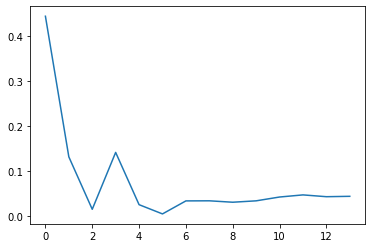

In [62]:
plt.plot(sil)
plt.show()

In [68]:
# set number of clusters
kclusters = 3

van_grouped_clustering = van_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0, n_init = 10).fit(van_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0], dtype=int32)

In [69]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

van_merged = df1  #Neighborhood + Location

# merge two tables to add latitude/longitude for each neighborhood
van_merged = van_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhoods')
#van_merged = pd.merge(van_merged, neighborhoods_venues_sorted, left_on='Neighborhoods', right_on='Neighborhood', how='right')

van_merged.head() # check the last columns!

,Neighborhoods,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Arbutus Ridge,49.257500,-123.174444,0,Japanese Restaurant,Baseball Field,Dessert Shop,Sandwich Place,Spa
1,Downtown,49.279983,-123.121120,0,Concert Hall,Toy / Game Store,Hotel,Bar,Dance Studio
2,Dunbar-Southlands,49.250000,-123.185000,0,Grocery Store,Sushi Restaurant,Cosmetics Shop,Café,Pub
3,Fairview,49.264000,-123.130000,0,Park,Restaurant,Pet Store,Pharmacy,Camera Store
4,Grandview-Woodland,49.275000,-123.067000,0,Park,Tapas Restaurant,Grocery Store,Cuban Restaurant,Cajun / Creole Restaurant


In [70]:
#drop rows that's not belong to any cluster
test=van_merged.dropna(subset=['Cluster Labels'])
test['Cluster Labels']= test['Cluster Labels'].astype(int)

#change columns 'Cluster Labels' type as int for folium map keep working
test.head()

,Neighborhoods,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Arbutus Ridge,49.257500,-123.174444,0,Japanese Restaurant,Baseball Field,Dessert Shop,Sandwich Place,Spa
1,Downtown,49.279983,-123.121120,0,Concert Hall,Toy / Game Store,Hotel,Bar,Dance Studio
2,Dunbar-Southlands,49.250000,-123.185000,0,Grocery Store,Sushi Restaurant,Cosmetics Shop,Café,Pub
3,Fairview,49.264000,-123.130000,0,Park,Restaurant,Pet Store,Pharmacy,Camera Store
4,Grandview-Woodland,49.275000,-123.067000,0,Park,Tapas Restaurant,Grocery Store,Cuban Restaurant,Cajun / Creole Restaurant


create the map of Clusters

In [71]:
# create map centered at lat, long of Toronto
latitude= 49.24966
longitude= -123.11934
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(test['Latitude'], test['Longitude'], test['Neighborhoods'], test['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Step 6: Examine Clusters

In [113]:
# 1st cluster
cluster1=van_merged.loc[van_merged['Cluster Labels'] == 0, van_merged.columns[[0] + list(range(3, van_merged.shape[1]))]]
cluster1

,Neighborhoods,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Arbutus Ridge,0,Japanese Restaurant,Baseball Field,Dessert Shop,Sandwich Place,Spa
1,Downtown,0,Concert Hall,Toy / Game Store,Hotel,Bar,Dance Studio
2,Dunbar-Southlands,0,Grocery Store,Sushi Restaurant,Cosmetics Shop,Café,Pub
3,Fairview,0,Park,Restaurant,Pet Store,Pharmacy,Camera Store
4,Grandview-Woodland,0,Park,Tapas Restaurant,Grocery Store,Cuban Restaurant,Cajun / Creole Restaurant
6,Kensington-Cedar Cottage,0,Vietnamese Restaurant,Bookstore,Chinese Restaurant,Grocery Store,Café
7,Kerrisdale,0,Japanese Restaurant,Vietnamese Restaurant,Thai Restaurant,Tea Room,Pharmacy
8,Killarney,0,Grocery Store,Sushi Restaurant,Coffee Shop,Gas Station,Pharmacy
9,Kitsilano,0,Café,Yoga Studio,Diner,Pizza Place,Pub
10,Marpole,0,Gym,Field,Liquor Store,Bike Rental / Bike Share,Diner


In [114]:
# 2nd cluster
cluster2=van_merged.loc[van_merged['Cluster Labels'] == 1, van_merged.columns[[0] + list(range(3, van_merged.shape[1]))]]
cluster2

,Neighborhoods,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
5,Hastings-Sunrise,1,Park,Diner,Coffee Shop,Concert Hall,Convenience Store


In [115]:
# 3rd cluster
cluster3=van_merged.loc[van_merged['Cluster Labels'] == 2, van_merged.columns[[0] + list(range(3, van_merged.shape[1]))]]
cluster3

,Neighborhoods,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
13,Renfrew-Collingwood,2,Bus Stop,Park,Flower Shop,Bar,Plaza
15,Shaughnessy,2,American Restaurant,Chocolate Shop,Park,Health & Beauty Service,Gas Station
17,Strathcona,2,Park,Brewery,Coffee Shop,Deli / Bodega,Restaurant
21,West Point Grey,2,Sandwich Place,Playground,Park,Yoga Studio,Chocolate Shop


### < f4 for each cluster, find the top 5 crime types>

In [116]:
cluster1=cluster1['Neighborhoods']
cluster1.head()

0         Arbutus Ridge
1              Downtown
2     Dunbar-Southlands
3              Fairview
4    Grandview-Woodland
Name: Neighborhoods, dtype: object

In [117]:
cluster1_type = pd.merge(cluster1, df_combine, left_on='Neighborhoods', right_on='Neighborhoods', how='left')
cluster1_type.drop(['Latitude','Longitude'], axis=1, inplace=True)
cluster1_type.head()

,Neighborhoods,TYPE,YEAR
0,Arbutus Ridge,Break and Enter Commercial,2005.0
1,Arbutus Ridge,Break and Enter Commercial,2007.0
2,Arbutus Ridge,Break and Enter Commercial,2016.0
3,Arbutus Ridge,Break and Enter Commercial,2016.0
4,Arbutus Ridge,Break and Enter Commercial,2005.0


In [118]:
cluster1_test= cluster1_type.groupby(['Neighborhoods', 'TYPE']).count().sort_values(by=['Neighborhoods','YEAR'], ascending=False)
cluster1_test

YEAR
Neighborhoods TYPE                                    
West End      Theft from Vehicle                 20401
              Other Theft                         7256
              Mischief                            6420
              Break and Enter Residential/Other   3649
              Theft of Bicycle                    3449
...                                                ...
Arbutus Ridge Break and Enter Residential/Other   1848
              Mischief                            1041
              Other Theft                          386
              Break and Enter Commercial           352
              Theft of Bicycle                     209

[113 rows x 1 columns]

In [119]:
# install wordcloud
!conda install -c conda-forge wordcloud==1.4.1 --yes

# import package and its set of stopwords
from wordcloud import WordCloud, STOPWORDS

print ('Wordcloud is installed and imported!')


Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.8.2

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Wordcloud is installed and imported!


In [120]:
#get the crimes in group 1
lll= cluster1_type.groupby(['TYPE']).count().sort_values(by=['Neighborhoods'], ascending=False)
lll.drop(['Neighborhoods'], axis=1, inplace=True)
lll.rename(columns={'YEAR': 'Crimes'}, inplace=True)

data = dict(zip(lll.index.values.tolist(), lll['Crimes'].tolist()))
print(lll)

                                   Crimes
TYPE                                     
Theft from Vehicle                 173281
Mischief                            67834
Other Theft                         56261
Break and Enter Residential/Other   52281
Break and Enter Commercial          33296
Theft of Bicycle                    27825
Theft of Vehicle                     1828


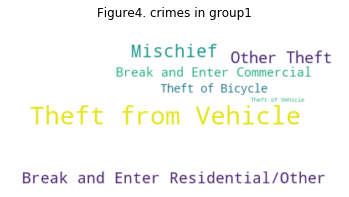

In [121]:
# display the word cloud
wordcloud = WordCloud(background_color="white").generate_from_frequencies(data)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Figure4. crimes in group1')
plt.show()

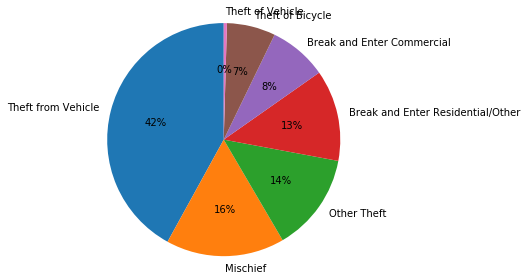

In [122]:
# Create a pie chart
plt.pie(
    lll['Crimes'],
    labels=lll.index.values,
    shadow=False,
    startangle=90,
    autopct='%1.f%%',
    )

# View the plot drop above
plt.axis('equal')

# View the plot
plt.tight_layout()
plt.show()

### </ f4>

### < f5: find crimes in group2 by word plot>

In [123]:
cluster2=cluster2['Neighborhoods']

cluster2_type = pd.merge(cluster2, df_combine, left_on='Neighborhoods', right_on='Neighborhoods', how='left')
cluster2_type.drop(['Latitude','Longitude'], axis=1, inplace=True)

cluster2_test= cluster2_type.groupby(['Neighborhoods', 'TYPE']).count().sort_values(by=['Neighborhoods','YEAR'], ascending=False)
cluster2_test

YEAR
Neighborhoods    TYPE                                   
Hastings-Sunrise Theft from Vehicle                 7126
                 Break and Enter Residential/Other  3500
                 Mischief                           3404
                 Other Theft                        1608
                 Break and Enter Commercial         1036
                 Theft of Bicycle                    471
                 Theft of Vehicle                     38

                                   Crimes
TYPE                                     
Theft from Vehicle                   7126
Break and Enter Residential/Other    3500
Mischief                             3404
Other Theft                          1608
Break and Enter Commercial           1036
Theft of Bicycle                      471
Theft of Vehicle                       38


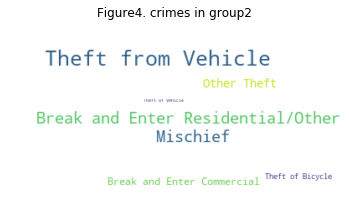

In [124]:
lll= cluster2_type.groupby(['TYPE']).count().sort_values(by=['Neighborhoods'], ascending=False)
lll.drop(['Neighborhoods'], axis=1, inplace=True)
lll.rename(columns={'YEAR': 'Crimes'}, inplace=True)
data = dict(zip(lll.index.values.tolist(), lll['Crimes'].tolist()))
print(lll)

wordcloud = WordCloud(background_color="white").generate_from_frequencies(data)
# display the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Figure4. crimes in group2')
plt.show()

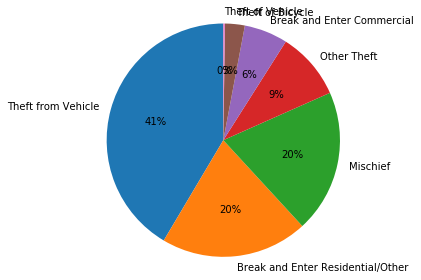

In [125]:
# Create a pie chart
plt.pie(
    lll['Crimes'],
    labels=lll.index.values,
    shadow=False,
    startangle=90,
    autopct='%1.f%%',
    )

# View the plot drop above
plt.axis('equal')

# View the plot
plt.tight_layout()
plt.show()

### </ f5>

### < f6: find crimes in group3 by word plot>

In [126]:
cluster3=cluster3['Neighborhoods']

cluster3_type = pd.merge(cluster3, df_combine, left_on='Neighborhoods', right_on='Neighborhoods', how='left')
cluster3_type.drop(['Latitude','Longitude'], axis=1, inplace=True)

cluster3_test= cluster3_type.groupby(['Neighborhoods', 'TYPE']).count().sort_values(by=['Neighborhoods','YEAR'], ascending=False)
cluster3_test

YEAR
Neighborhoods       TYPE                                    
West Point Grey     Theft from Vehicle                  2355
                    Break and Enter Residential/Other   1435
                    Mischief                            1031
                    Theft of Bicycle                     446
                    Break and Enter Commercial           365
                    Other Theft                          297
Strathcona          Theft from Vehicle                  9349
                    Mischief                            5773
                    Break and Enter Commercial          2580
                    Break and Enter Residential/Other   2312
                    Theft of Bicycle                    1288
                    Other Theft                         1252
                    Theft of Vehicle                      91
Shaughnessy         Theft from Vehicle                  2142
                    Break and Enter Residential/Other   2040
                    Mischief                             730
                    Theft of Bicycle                     165
                    Break and Enter Commercial           157
                    Theft of Vehicle                      51
                    Other Theft                           28
Renfrew-Collingwood Theft from Vehicle                 10024
                    Other Theft                         5141
                    Break and Enter Residential/Other   4645
                    Mischief                            4507
                    Break and Enter Commercial          1369
                    Theft of Bicycle                     520

                                   Crimes
TYPE                                     
Theft from Vehicle                  23870
Mischief                            12041
Break and Enter Residential/Other   10432
Other Theft                          6718
Break and Enter Commercial           4471
Theft of Bicycle                     2419
Theft of Vehicle                      142


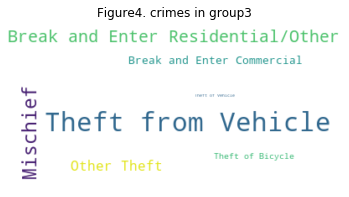

In [127]:
lll= cluster3_type.groupby(['TYPE']).count().sort_values(by=['Neighborhoods'], ascending=False)
lll.drop(['Neighborhoods'], axis=1, inplace=True)
lll.rename(columns={'YEAR': 'Crimes'}, inplace=True)
data = dict(zip(lll.index.values.tolist(), lll['Crimes'].tolist()))
print(lll)

wordcloud = WordCloud(background_color="white").generate_from_frequencies(data)
# display the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Figure4. crimes in group3')
plt.show()

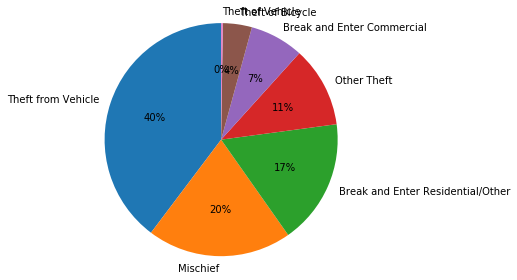

In [128]:
# Create a pie chart
plt.pie(
    lll['Crimes'],
    labels=lll.index.values,
    shadow=False,
    startangle=90,
    autopct='%1.f%%',
    )

# View the plot drop above
plt.axis('equal')

# View the plot
plt.tight_layout()
plt.show()

### < /f6>